__<span style="background-color:#ffffe0">第3章　時系列予測モデル構築・超入門</span>__

# 3.5　多変量時系列データの特徴把握と因果探索

## 3.5.4　VARモデルで実施

### 準備（必要なモジュールとデータの読み込み）

In [1]:
#
# 必要なモジュールの読み込み
#

import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.svar_model import SVAR

from graphviz import Digraph

import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
plt.style.use('ggplot') #グラフのスタイル
plt.rcParams['figure.figsize'] = [12, 9] # グラフサイズ設定
plt.rcParams['font.size'] = 14 #フォントサイズ

In [2]:
#
# 必要なデータセット（時系列データ）の読み込み
#

dataset='MMM.csv' #データセットのファイル名
df = pd.read_csv(
    dataset,
    parse_dates=True,
    index_col='day')

print(df) #確認

                  Sales     OfflineAD    OnlineAD
day                                              
2019-01-01  2421099.200  8.255520e+05  289099.200
2019-01-02  2893768.826  8.065540e+05  297668.826
2019-01-03  2667494.968  6.178813e+05  208972.890
2019-01-04  2016377.026  1.003793e+06  166375.482
2019-01-05  2511385.175  6.651360e+05  230455.368
...                 ...           ...         ...
2019-06-26  2373450.715  1.120225e+06  138594.564
2019-06-27  1860416.854  1.148680e+06  174731.142
2019-06-28  2546100.284  9.110840e+05  138329.496
2019-06-29  2961440.424  9.963220e+05  265571.064
2019-06-30  3322232.779  6.408697e+05  313092.000

[181 rows x 3 columns]


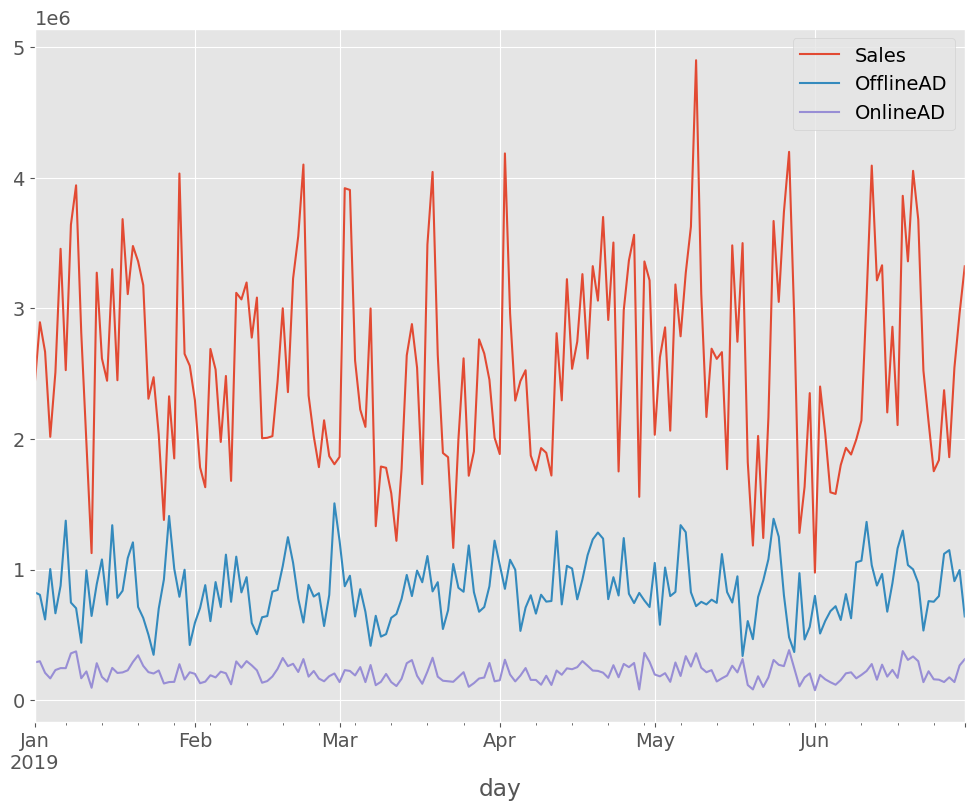

In [3]:
#
# 時系列データのグラフ化（折れ線グラフ）
#

df.plot()
plt.show()

### VARモデルで変数間の関係性を検討

#### 単位根検定

In [4]:
#
# Augmented Dickey-Fuller 単位根検定
#   帰無仮説：単位根がある
#   対立仮説：定数項＋定常過程
#

for i in range(len(df.columns)):
    
    #Augmented Dickey-Fuller 単位根検定
    c_results = adfuller(df.iloc[:,i],regression='c')  
    
    #p値出力
    print(df.columns[i],'\t',c_results[1]) 

Sales 	 1.3316913900397309e-14
OfflineAD 	 4.2647145786943144e-11
OnlineAD 	 1.6399421694391905e-08


#### VARモデルの構築

In [5]:
#
# VARモデルの構築
#

# 最大のラグ数
maxlags = 10

# モデルのインスタンス生成
var_model = VAR(df)

# 最適なラグの探索
lag = var_model.select_order(maxlags).selected_orders
print('最適なラグ：',lag['aic'],'\n')

# モデルの学習
results = var_model.fit(lag['aic'])

# 結果出力
print(results.summary())

最適なラグ： 3 

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 31, May, 2023
Time:                     16:28:33
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    72.4635
Nobs:                     178.000    HQIC:                   72.1447
Log likelihood:          -7129.24    FPE:                1.72885e+31
AIC:                      71.9272    Det(Omega_mle):     1.46739e+31
--------------------------------------------------------------------
Results for equation Sales
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const           -83731.484470    237565.067117           -0.352           0.724
L1.Sales             0.019934         0.121779            0.164           0.870
L1.OfflineAD         0.396654         0.168040       

#### グレンジャー因果性の検定

In [6]:
#
# グレンジャー因果性の検定
#   帰無仮説：グレンジャー因果なし
#   対立仮説：グレンジャー因果あり
#

for i in range(len(df.columns)):
    for j in range(len(df.columns)):
        if i != j :
            #因果の検定
            test_results = results.test_causality(causing=i, caused=j) 
            #p値
            test_results.pvalue
            #検定結果の出力
            print(df.columns[i],'->',df.columns[j],'\t',test_results.pvalue)

Sales -> OfflineAD 	 0.14686257982415893
Sales -> OnlineAD 	 0.7848913815447163
OfflineAD -> Sales 	 1.8937325083324138e-36
OfflineAD -> OnlineAD 	 4.839521581678628e-10
OnlineAD -> Sales 	 0.4299534534728454
OnlineAD -> OfflineAD 	 0.4788944144467945


#### 有向グラフ（VARのみ考慮）

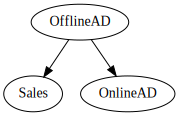

In [7]:
#
# 有向グラフ（VARのみ考慮）
#

# インスタンスの生成
graph = Digraph()

# グラフにノードを追加
for i in range(len(df.columns)):
    graph.node(df.columns[i])

# 因果を検定し有意なとき線を引く
for i in range(len(df.columns)):
    for j in range(len(df.columns)):
        if i != j :
            #因果の検定
            test_results = results.test_causality(causing=i, caused=j) 
            #p値が0.05未満のとき線を追加
            if test_results.pvalue < 0.05:
                graph.edge(df.columns[i], df.columns[j])
            
# 有向グラフを表示
graph

#### インパルス応答関数(直交化)

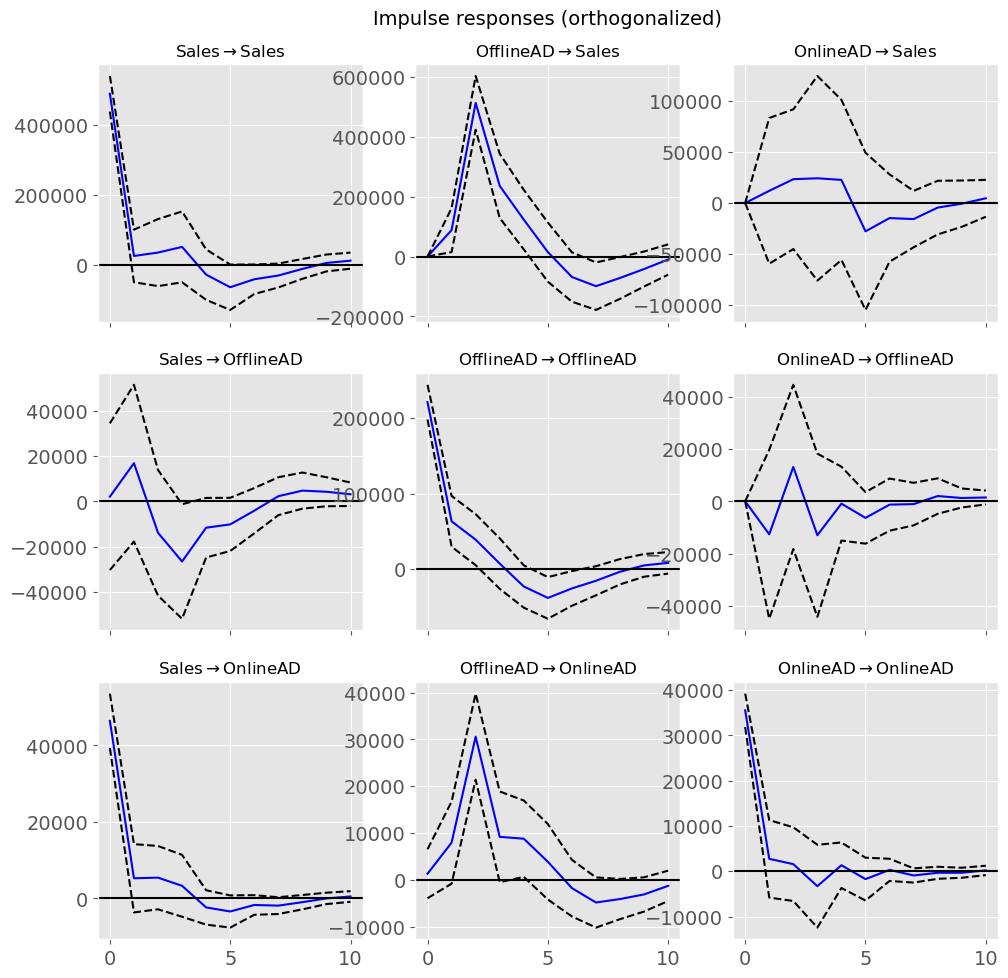

In [8]:
#
# インパルス応答関数(直交化)
#

irf = results.irf()
irf.plot(orth=True)
plt.show()

### SVARモデル

#### SVARモデルの構築

In [9]:
#
# SVARモデルの構築
#

#　目的変数の行列Aの定義
A_0 = np.array([[1, 'E','E'],
                ['E', 1,'E'], 
                ['E','E', 1]])

# モデルのインスタンス生成
SVAR_model = SVAR(df, svar_type='A', A=A_0)

# 学習
results = SVAR_model.fit(maxlags=3)

#　推定結果（目的変数の行列A）
results.A

array([[ 1.00000000e+00,  3.11121766e-02, -6.62109818e+00],
       [ 1.72367573e-02,  1.00000000e+00, -2.26620564e-01],
       [-9.51650281e-02, -5.87927465e-03,  1.00000000e+00]])

#### インパルス応答関数(構造)

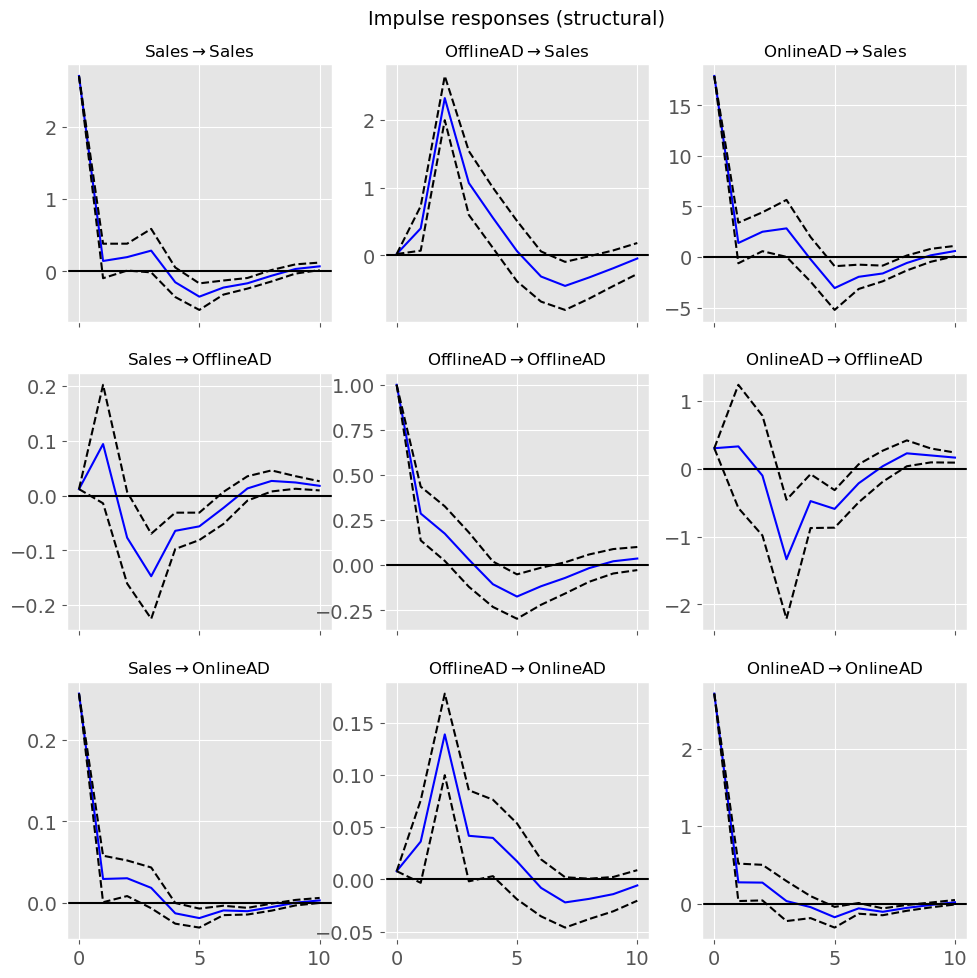

In [10]:
#
# インパルス応答関数(構造)
#

irf = results.irf()
irf.plot()
plt.show()

#### 有向グラフ（VAR＋線形回帰）

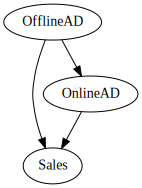

In [11]:
#
# 有向グラフ（VAR＋線形回帰）
#

graph = Digraph()

# ノードを追加
for i in range(len(df.columns)):
    graph.node(df.columns[i])

# 辺を追加
graph.edge(df.columns[1], df.columns[0])
graph.edge(df.columns[2], df.columns[0])
graph.edge(df.columns[1], df.columns[2])

# 画像を表示
graph